In [110]:
print("Hello")

Hello


In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix, classification_report
import pickle

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [113]:
df = pd.read_csv('/content/drive/MyDrive/NLP_Project/emotion_sentimen_dataset.csv')

In [114]:
df.shape

(839555, 3)

In [115]:
df.sample(10)

,Unnamed: 0,text,Emotion
764966,764966,i feel more comfortable doing the subway tile ...,relief
480345,480345,i understand that our society has sexualized b...,relief
491231,491231,i feel dirty for listening to melodic synth wi...,neutral
452503,452503,i feel that everythings gonna be ok that feeli...,happiness
452229,452229,i know i m jinxing myself by writing all this ...,neutral
642757,642757,i feel so carefree and happy now all the time,happiness
728361,728361,i feel like this has probably damaged my hair ...,neutral
441295,441295,im feeling more optimistic than i have in a lo...,neutral
674527,674527,i just feel accepted and comfort by all the fi...,relief
729116,729116,i feel more useless i dont know how to be moti...,neutral


In [116]:
df['Emotion'].unique()

array(['hate', 'neutral', 'anger', 'love', 'worry', 'relief', 'happiness',
       'fun', 'empty', 'enthusiasm', 'sadness', 'surprise', 'boredom'],
      dtype=object)

In [117]:
# Given list of labels
labels_name = ['surprise', 'worry', 'hate', 'happiness', 'sadness', 'anger', 'neutral']

# Filter the DataFrame to only include rows with labels in labels_name
df = df[df['Emotion'].isin(labels_name)]

# Display the filtered DataFrame
df.head()

,Unnamed: 0,text,Emotion
0,0,i seriously hate one subject to death but now ...,hate
1,1,im so full of life i feel appalled,neutral
2,2,i sit here to write i start to dig out my feel...,neutral
3,3,ive been really angry with r and i feel like a...,anger
4,4,i feel suspicious if there is no one outside l...,neutral


In [118]:
df['Emotion'].unique()

array(['hate', 'neutral', 'anger', 'worry', 'happiness', 'sadness',
       'surprise'], dtype=object)

In [119]:
# removing the duplicates
df = df.drop_duplicates()

In [120]:
df.isnull().sum()

Unnamed: 0    0
text          0
Emotion       0
dtype: int64

In [121]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [122]:
df.sample(10)

,text,Emotion
231603,im refusing to write how i felt last night whe...,neutral
132825,i am feeling why i think i feel this way and m...,happiness
629624,i just want someone to sympathize with me that...,neutral
484028,i feel more productive and healthy after a class,neutral
83084,i have the freedom to be who i am without feel...,neutral
239341,i have been using them for any dry spots and i...,happiness
165802,i feel the beginnings of a positive relationship,neutral
261199,i feel is boring definitely a good product for...,neutral
636136,i need is a little tweaking in the goals depar...,neutral
572916,i count as friends i nevertheless wanted to cr...,neutral


([<matplotlib.patches.Wedge at 0x7a25bc96b3a0>,
 [Text(-1.0815551259436589, 0.3908177446649477, 'neutral'),
  Text(0.9613636153592678, -0.6310942869836152, 'happiness'),
  Text(1.0610579568622969, -0.44345914375420004, 'sadness'),
  Text(1.1112923489370858, -0.29585353672703435, 'hate'),
  Text(1.13779498574693, -0.16710047997879438, 'anger'),
  Text(1.147504101528836, -0.07572540507979472, 'surprise'),
  Text(1.149802326780106, -0.02132156961985259, 'worry')],
 [Text(-0.6113137668377202, 0.2208969861149704, '89.0%'),
  Text(0.5433794347682818, -0.3567054665559564, '3.6%'),
  Text(0.5997284104004287, -0.25065082038280867, '2.3%'),
  Text(0.6281217624427005, -0.1672215642370194, '2.0%'),
  Text(0.6431015136830474, -0.09444809737931856, '1.6%'),
  Text(0.6485892747771681, -0.04280131591466658, '0.9%'),
  Text(0.6498882716583207, -0.012051321959047116, '0.6%')])

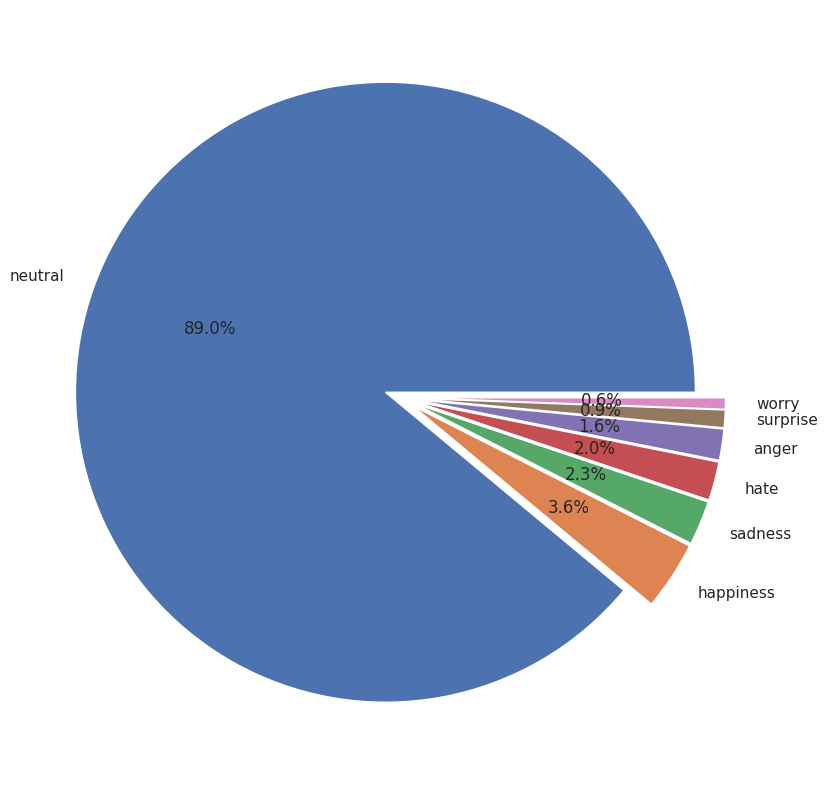

In [123]:
value_counts = df['Emotion'].value_counts()
plt.figure(figsize=(10,18))
plt.xticks(rotation=75)  # Rotating x-axis labels for better visibility
plt.pie(value_counts.values, labels=value_counts.index,explode=[0.05]*df['Emotion'].nunique(),autopct='%1.1f%%')

In [124]:
# Define a dictionary of chat word mappings
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [125]:
# Function to replace chat words with their full forms
def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)

# Apply replace_chat_words function to 'Text' column
df['text'] = df['text'].apply(replace_chat_words)

In [126]:
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

df.head()

,text,Emotion
0,i seriously hate one subject to death but now ...,hate
1,im so full of life i feel appalled,neutral
2,i sit here to write i start to dig out my feel...,neutral
3,ive been really angry with r and i feel like a...,anger
4,i feel suspicious if there is no one outside l...,neutral


In [127]:
stop = stopwords.words('english')
df["text"] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

df.head()

,text,Emotion
0,seriously hate one subject death feel reluctan...,hate
1,im full life feel appalled,neutral
2,sit write start dig feelings think afraid acce...,neutral
3,ive really angry r feel like idiot trusting fi...,anger
4,feel suspicious one outside like rapture happe...,neutral


In [128]:
df['text'] = df['text'].str.lower()
print(df.head())

                                                text  Emotion
0  seriously hate one subject death feel reluctan...     hate
1                         im full life feel appalled  neutral
2  sit write start dig feelings think afraid acce...  neutral
3  ive really angry r feel like idiot trusting fi...    anger
4  feel suspicious one outside like rapture happe...  neutral


In [129]:
df['text'] = df['text'].str.replace(r'\d+', '', regex=True)
df.head()

,text,Emotion
0,seriously hate one subject death feel reluctan...,hate
1,im full life feel appalled,neutral
2,sit write start dig feelings think afraid acce...,neutral
3,ive really angry r feel like idiot trusting fi...,anger
4,feel suspicious one outside like rapture happe...,neutral


In [130]:
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True)
print(df.head())

                                                text  Emotion
0  seriously hate one subject death feel reluctan...     hate
1                         im full life feel appalled  neutral
2  sit write start dig feelings think afraid acce...  neutral
3  ive really angry r feel like idiot trusting fi...    anger
4  feel suspicious one outside like rapture happe...  neutral


In [131]:
df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)
print(df.head())

                                                text  Emotion
0  seriously hate one subject death feel reluctan...     hate
1                         im full life feel appalled  neutral
2  sit write start dig feelings think afraid acce...  neutral
3  ive really angry r feel like idiot trusting fi...    anger
4  feel suspicious one outside like rapture happe...  neutral


In [132]:
df['text'] = df['text'].str.replace(r'http\S+', '', regex=True)
print(df.head())

                                                text  Emotion
0  seriously hate one subject death feel reluctan...     hate
1                         im full life feel appalled  neutral
2  sit write start dig feelings think afraid acce...  neutral
3  ive really angry r feel like idiot trusting fi...    anger
4  feel suspicious one outside like rapture happe...  neutral


In [133]:
# Initialize the PorterStemmer
stemmer = PorterStemmer()

# Function to apply stemming to a text
def apply_stemming(text):
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

# Apply stemming to the 'text' column
df['text'] = df['text'].apply(apply_stemming)

In [134]:
def bar_graph(emotion):
    love_texts = df[df['Emotion'] == emotion]['text']

    # Tokenize the text and count the frequency of each word
    words = [word.lower() for text in love_texts for word in word_tokenize(text)]
    word_freq = Counter(words)

    # Get the top 20 words
    top_20_words = dict(word_freq.most_common(20))

    # Set the background color and theme
    background_color = '#5fa1bc'
    sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

    # Create a bar plot
    plt.figure(figsize=(10, 5))
    p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
    for container in p.containers:
        plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                      bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
    plt.title(f"Top 20 Words Associated with '{emotion}'", fontsize=20, fontweight='bold')
    plt.xlabel("Words", fontsize=10 )
    plt.ylabel("Frequency", fontsize=10)
    plt.xticks(rotation=80, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
plt.show()

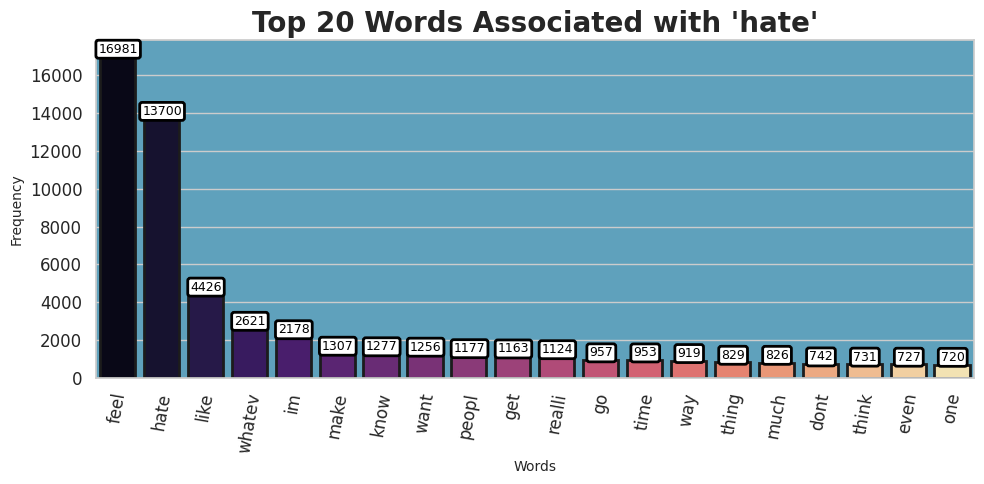

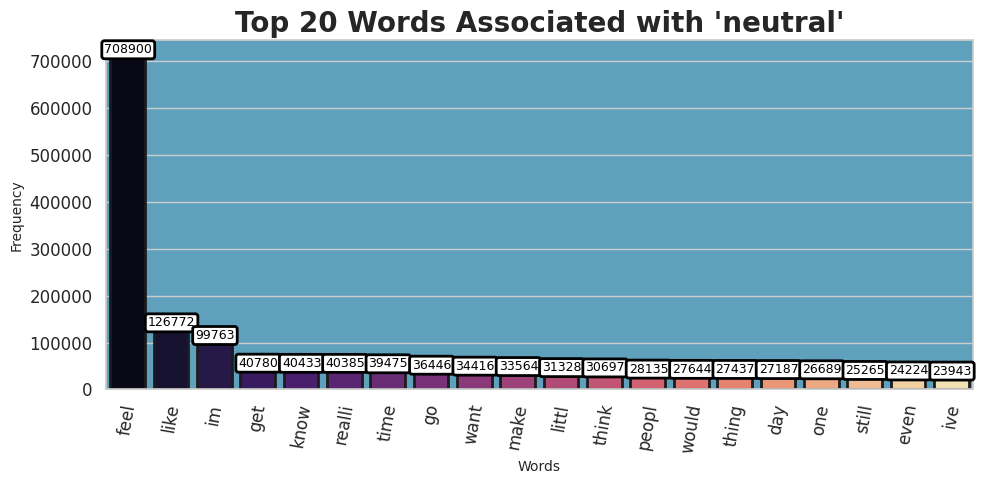

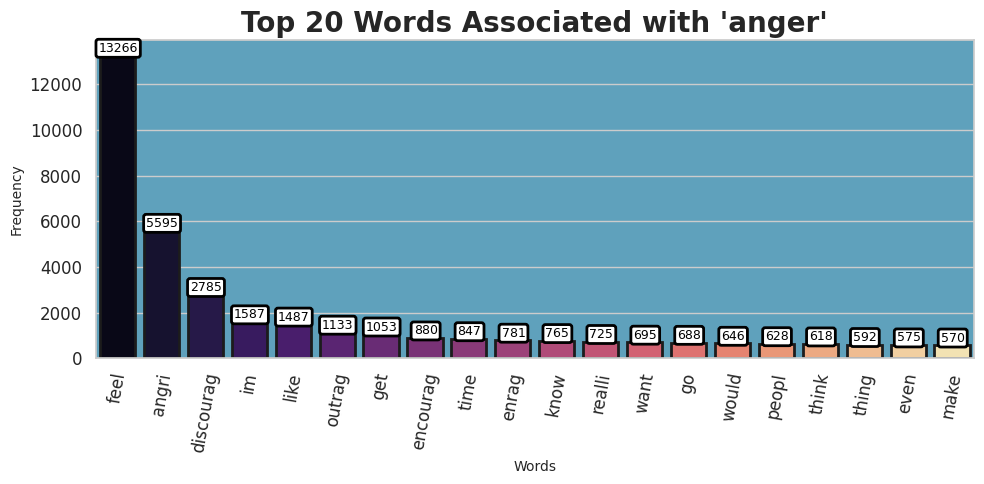

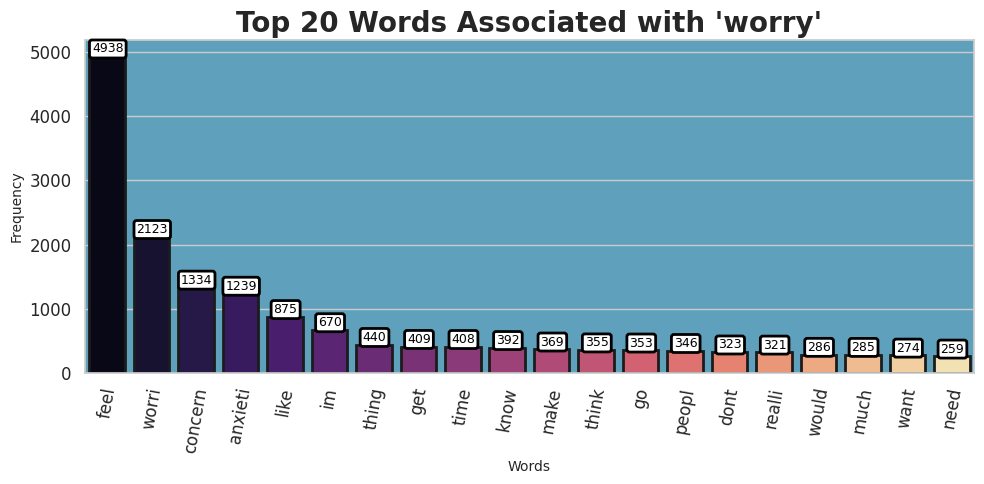

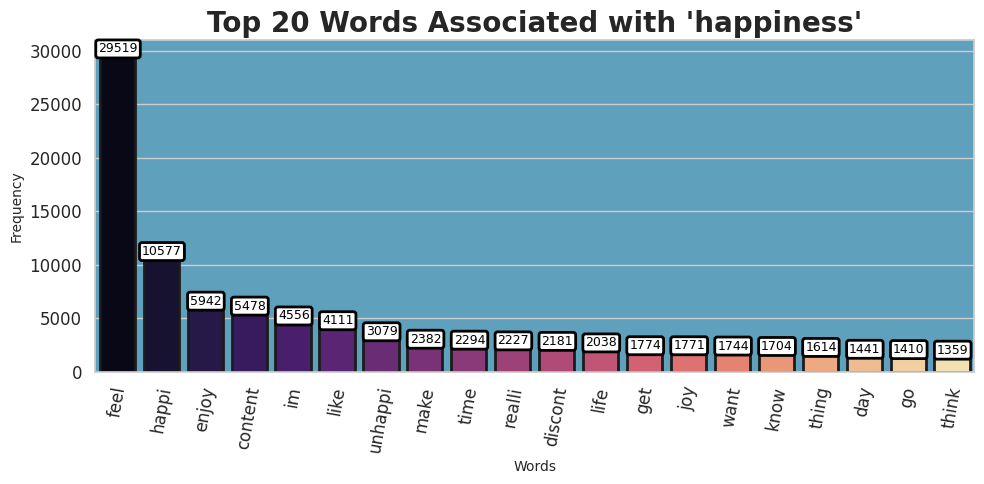

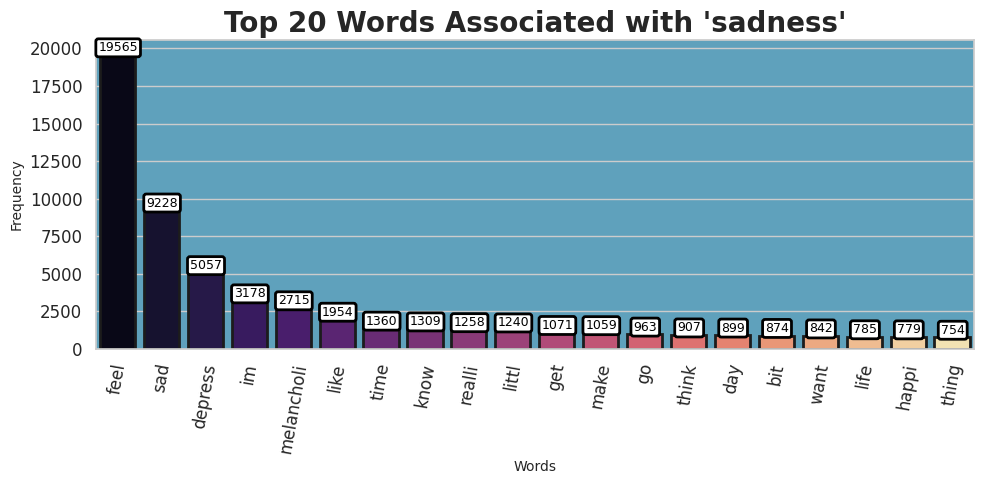

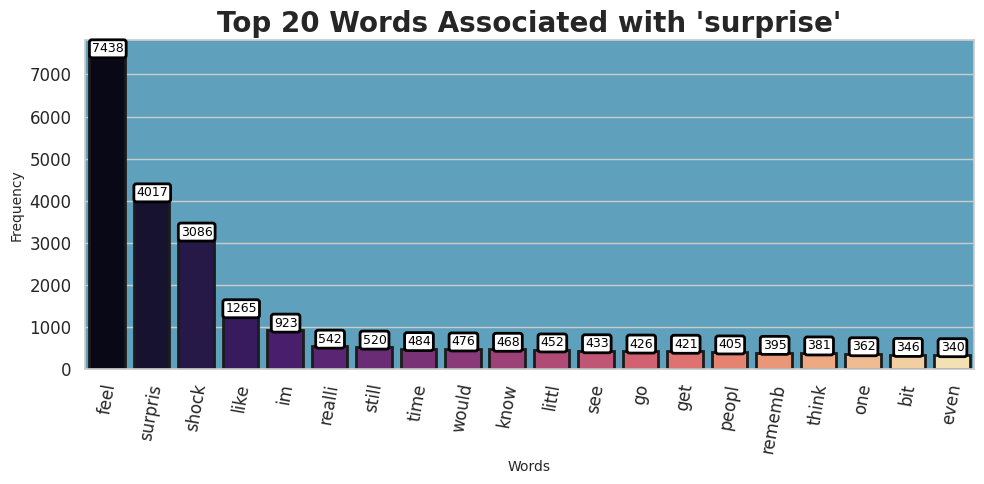

In [135]:
for emotion in df['Emotion'].unique():
    bar_graph(emotion)

In [ ]:
df['Emotion'].unique()

In [137]:
# Define a mapping dictionary
label_mapping = {'surprise':0, 'worry':1, 'hate':2, 'happiness':3, 'sadness':4, 'anger':5, 'neutral':6}

In [138]:


# Rename the 'Label' column using the mapping dictionary
df['Emotion-String'] = df['Emotion']
df['Emotion'] = df['Emotion'].map(label_mapping)

In [139]:
#  now you can see that the fear sadness etc convert into numbers which will make our
# task easy in terms of computation and speed
df.head()

,text,Emotion,Emotion-String
0,serious hate one subject death feel reluct drop,2,hate
1,im full life feel appal,6,neutral
2,sit write start dig feel think afraid accept p...,6,neutral
3,ive realli angri r feel like idiot trust first...,5,anger
4,feel suspici one outsid like raptur happen someth,6,neutral


In [140]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['Emotion']

# Split the data into training and temporary sets
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the temporary data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.125, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("The shape of X_train is ", X_train.shape)
print("The shape of X_val is ", X_val.shape)
print("The shape of X_test is ", X_test.shape)
print("The shape of y_train is", y_train.shape)
print("The shape of y_val is", y_val.shape)
print("The shape of y_test is", y_test.shape)


The shape of X_train is  (530757,)
The shape of X_val is  (75823,)
The shape of X_test is  (151646,)
The shape of y_train is (530757,)
The shape of y_val is (75823,)
The shape of y_test is (151646,)


In [141]:
type(y_train)

pandas.core.series.Series

In [142]:
tokenizer = Tokenizer(num_words=60000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
tokenizer.fit_on_texts(X_val)

In [143]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

In [ ]:
# Maximum Length in X_train_sequences
maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

In [ ]:
# Perform padding on X_train and X_test sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=maxlen, padding='post')

In [146]:
type(X_train_padded)

numpy.ndarray

In [147]:
# Print the padded sequences for X_train and X_test
print("X_train_padded:")
print(X_train_padded)
print("\nX_test_padded:")
print(X_test_padded)
print("\nX_val_padded:")
print(X_val_padded)

X_train_padded:
[[   1    2  257 ...    0    0    0]
 [  27   44  594 ...    0    0    0]
 [2305 1496 2588 ...    0    0    0]
 ...
 [   1    5  355 ...    0    0    0]
 [  52    1  258 ...    0    0    0]
 [ 159    1  655 ...    0    0    0]]

X_test_padded:
[[    1   179   507 ...     0     0     0]
 [    1    22    85 ...     0     0     0]
 [   62   107    10 ...     0     0     0]
 ...
 [    1   191   125 ...     0     0     0]
 [   26     1     2 ...     0     0     0]
 [   57 24587   110 ...     0     0     0]]

X_val_padded:
[[   1   54  285 ...    0    0    0]
 [ 240   31    1 ...    0    0    0]
 [   6   49    1 ...    0    0    0]
 ...
 [  95    1    2 ...    0    0    0]
 [   1 3229  383 ...    0    0    0]
 [   1    2  643 ...    0    0    0]]


In [148]:
%cd /content/drive/MyDrive/NLP_Project

/content/drive/MyDrive/NLP_Project


In [149]:
# Assuming you have a trained tokenizer named 'tokenizer'
# Save the tokenizer to a file
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [150]:
# Embedding Input Size
input_size = np.max(X_train_padded) + 1
input_size

46277

In [151]:
# Define the model
model = Sequential()

# Add an embedding layer
model.add(Embedding(input_dim=input_size, output_dim=100,input_shape=(79,)))

# Add a bidirectional model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Set return_sequences=True
model.add(Bidirectional(LSTM(128)))  # Set return_sequences=True

# Add batch normalization layer
model.add(BatchNormalization())

# Add dropout regularization
model.add(Dropout(0.5))

# Add a dense layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu'))

# Add dropout regularization
model.add(Dropout(0.5))

# Add the output layer with 6 units for 6 labels and softmax activation
model.add(Dense(7, activation='softmax'))

In [152]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 79, 100)           4627700   
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               234496    
 onal)                                                           
                                                                 
 batch_normalization_2 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dropout_5 (Dropout)         (None, 64)               

In [153]:
import tensorflow as tf

# Ensure TensorFlow uses GPU if available
if tf.config.experimental.list_physical_devices('GPU'):
    print("Training on GPU")
else:
    print("No GPU found, training on CPU")

Training on GPU


In [154]:
# Model Train
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_data=(X_val_padded, y_val),callbacks=[EarlyStopping(patience=3)])

Epoch 1/5
16587/16587 [==============================] - 197s 12ms/step - loss: 0.0560 - accuracy: 0.9860 - val_loss: 0.0209 - val_accuracy: 0.9936
Epoch 2/5
16587/16587 [==============================] - 178s 11ms/step - loss: 0.0249 - accuracy: 0.9928 - val_loss: 0.0201 - val_accuracy: 0.9943
Epoch 3/5
16587/16587 [==============================] - 176s 11ms/step - loss: 0.0192 - accuracy: 0.9943 - val_loss: 0.0183 - val_accuracy: 0.9952
Epoch 4/5
16587/16587 [==============================] - 178s 11ms/step - loss: 0.0159 - accuracy: 0.9956 - val_loss: 0.0184 - val_accuracy: 0.9956
Epoch 5/5
16587/16587 [==============================] - 182s 11ms/step - loss: 0.0125 - accuracy: 0.9967 - val_loss: 0.0216 - val_accuracy: 0.9964


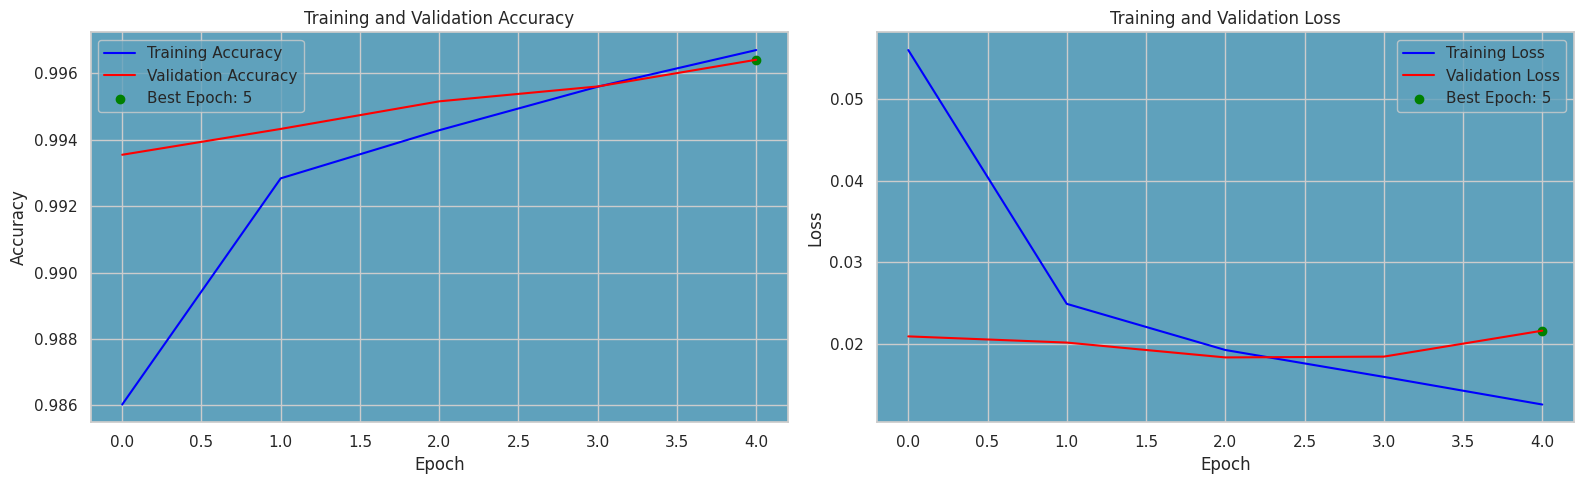

In [225]:
# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()


In [226]:
# Evaluate Test Data  [0.040432158857584, 0.990494966506958]

model.evaluate(X_test_padded, y_test)

4739/4739 [==============================] - 21s 4ms/step - loss: 0.0192 - accuracy: 0.9967


[0.019216854125261307, 0.9966962337493896]

In [227]:
# Predictions On Test For Confustion Matrix
y_pred = model.predict(X_test_padded)
y_pred

4739/4739 [==============================] - 18s 4ms/step


array([[1.20363263e-16, 2.39895406e-18, 2.61239043e-16, ...,
        4.85965706e-13, 1.61116097e-12, 1.00000000e+00],
       [9.89212473e-18, 6.71406290e-17, 2.32701296e-15, ...,
        1.28139305e-11, 2.35455882e-12, 1.00000000e+00],
       [2.15363945e-21, 4.95420869e-25, 5.66433379e-20, ...,
        2.93636190e-15, 7.20950372e-13, 1.00000000e+00],
       ...,
       [3.30074605e-16, 3.63167944e-16, 2.82734219e-15, ...,
        3.61215918e-11, 5.86179369e-11, 1.00000000e+00],
       [5.65856417e-10, 2.24760575e-12, 4.51723658e-11, ...,
        5.93828808e-09, 2.57696553e-09, 1.00000000e+00],
       [2.07445175e-25, 7.89503275e-24, 7.38484259e-19, ...,
        3.39338678e-15, 1.16573712e-17, 1.00000000e+00]], dtype=float32)

In [228]:

y_pred = np.argmax(y_pred, axis=1)

In [229]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1376
           1       0.94      0.91      0.92       841
           2       0.99      1.00      0.99      3049
           3       0.99      0.99      0.99      5486
           4       0.99      0.98      0.98      3510
           5       0.99      0.98      0.99      2379
           6       1.00      1.00      1.00    135005

    accuracy                           1.00    151646
   macro avg       0.98      0.98      0.98    151646
weighted avg       1.00      1.00      1.00    151646



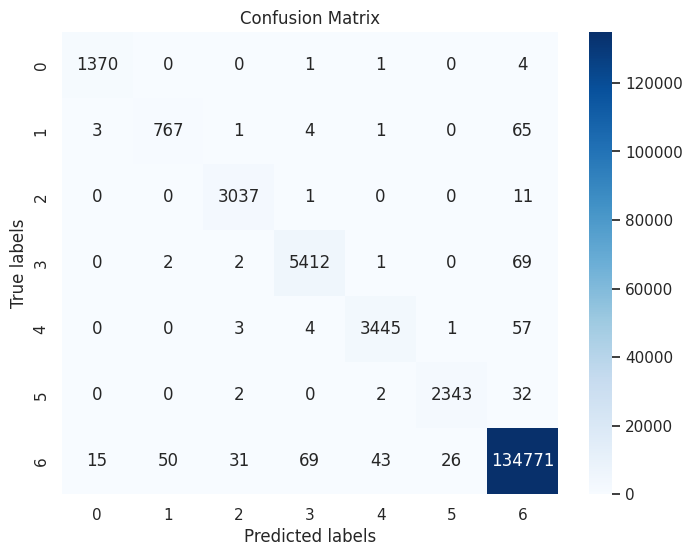

In [236]:
# y_test and y_pred are your true and predicted labels
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix with blue color
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # Change 'Reds' to 'Blues' for blue color
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
%cd /content/drive/MyDrive/NLP_Project

In [ ]:
model.save_weights('sentiment_classification_based_on_text.weights.h5')  # Saves weights in HDF5 format (.h5)


In [163]:
model.save("sentiment_classification_based_on_text.h5")

In [199]:
%cd /content/drive/MyDrive/NLP_Project

/content/drive/MyDrive/NLP_Project


In [200]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
loaded_model = load_model('sentiment_classification_based_on_text.h5')

In [201]:
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Example compilation


In [202]:
# Define a dictionary of chat word mappings
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [203]:
# Define a mapping dictionary
label_mapping = {'surprise':0, 'worry':1, 'hate':2, 'happiness':3, 'sadness':4, 'anger':5, 'neutral':6}

In [204]:
test = ["I hate you", "I love you and hate sometimes", "I am so happy today", "the problem is you I can't belive that everthing is realted to you it is a fucking problem"]

In [205]:
# Open the file for reading
with open("/content/drive/MyDrive/NLP_Project/sentences_video03.txt", "r") as text_file:
  # Create an empty list to store the lines
  test = []
  # Read each line from the file
  for line in text_file:
    # Remove any trailing newline character
    line = line.strip()
    # Add the line to the new array
    test.append(line)

In [206]:
test

['Hey, this is Ken from AES.',
 "Sometimes we're asked about the difference between what we do and a textbook.",
 "Let's talk about textbooks first.",
 'The best thing about a textbook is you can buy it once and you can keep using it for three or four years.']

In [207]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [208]:


def preprocess_text(text):

    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in [word.lower() for word in list(chat_words.keys())]:
            words[i] = chat_words[word]
    text = ' '.join(words)

    # Remove non-alphabetic and non-space characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove stopwords
    stop = stopwords.words('english')
    text = ' '.join([word for word in text.split() if word not in stop])

    # Convert to lowercase
    text = text.lower()

    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)

    # Remove non-alphanumeric characters
    text = re.sub(r'[^\w\s]', '', text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Initialize the PorterStemmer
    stemmer = PorterStemmer()
    # Function to apply stemming to a text
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    text =  ' '.join(stemmed_words)


    return text



In [209]:
test = [preprocess_text(text) for text in test]

In [210]:
test

['hey ken ae',
 'sometim ask differ textbook',
 'let talk textbook first',
 'the best thing textbook buy keep use three four year']

In [211]:
# Later, when you want to use the saved tokenizer:
# Load the tokenizer from the file
with open('/content/drive/MyDrive/NLP_Project/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Now you can use the loaded tokenizer to tokenize your text
tokenized_text = tokenizer.texts_to_sequences(test)

In [212]:
tokenized_text

[[1482, 6015, 17178],
 [88, 127, 236, 4725],
 [116, 86, 4725, 110],
 [37898, 235, 14, 4725, 611, 100, 46, 527, 1008, 43]]

In [213]:
test_sequence = tokenized_text

In [214]:
maxlen = 79

In [215]:
test_padded = pad_sequences(test_sequence, maxlen=maxlen, padding='post')

In [216]:
# Predictions On Test For Confustion Matrix
y_pred = loaded_model.predict(test_padded)
print(y_pred)

1/1 [==============================] - 1s 670ms/step
[[9.30251427e-13 1.30294115e-14 5.33976960e-11 1.08259313e-11
  4.80390424e-12 3.02956336e-13 1.00000000e+00]
 [1.76779850e-18 2.39250845e-20 2.18692492e-17 9.56213426e-18
  5.25495535e-16 3.04875914e-15 1.00000000e+00]
 [3.10017262e-16 9.65066451e-19 1.74370986e-15 9.63119761e-14
  6.79040916e-13 1.08939897e-12 1.00000000e+00]
 [2.95494966e-21 7.75759200e-22 2.70916767e-18 4.81240032e-18
  2.67075259e-16 9.00005197e-17 1.00000000e+00]]


In [217]:
import torch
from torch.nn import functional as F  # Import functional for softmax


# Create a PyTorch tensor
tensor = torch.tensor(y_pred)

# Apply softmax along the specified dimension (default is dim=1)
softmax_output = F.softmax(tensor, dim=1)

print(softmax_output)

tensor([[0.1147, 0.1147, 0.1147, 0.1147, 0.1147, 0.1147, 0.3118],
        [0.1147, 0.1147, 0.1147, 0.1147, 0.1147, 0.1147, 0.3118],
        [0.1147, 0.1147, 0.1147, 0.1147, 0.1147, 0.1147, 0.3118],
        [0.1147, 0.1147, 0.1147, 0.1147, 0.1147, 0.1147, 0.3118]])


In [218]:

# Convert softmax_output tensor to numpy array
softmax_array = softmax_output.cpu().detach().numpy()


In [219]:
%cd /content/drive/MyDrive/NLP_Project

/content/drive/MyDrive/NLP_Project


In [220]:

# Save the softmax arrays to a text file
with open("softmax_output_of_text.txt", "w") as file:
    for array in softmax_array:
        file.write(' '.join([str(elem) for elem in array]) + '\n')

In [221]:

y_pred = np.argmax(y_pred, axis=1)
y_pred

array([6, 6, 6, 6])

In [222]:
def get_key_from_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return None  # If the value is not found

In [223]:
results = [get_key_from_value(label_mapping, label) for label in y_pred]
results

['Nneutral', 'Nneutral', 'Nneutral', 'Nneutral']

In [224]:
softmax_output_of_text = 0